# Jessica Birky, Héctor Delgado Díaz, Samantha Gilbert

# Problem Set 3

## Exoplanets Spring 2020

### Problem 1
We install the dynamical integrator REBOUND using Python: https://
rebound.readthedocs.io/en/latest/.

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import math
import time
import tqdm
import os
from scipy.optimize import minimize
import astropy.constants as const
from astropy import units as u
import rebound

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':20})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

G = 6.674e-8

folders = ['results', 'plots']
for ff in folders:
    if not os.path.exists(ff):
        os.mkdir(ff)

### Problem 2

We look up the parameters of the planet system GJ 876, and assuming the planets’ orbits
are coplanar, we vary the inclination of the system.

In [2]:
# We obtain stellar and planet parameters from the Exoplanet Archive.
# Mass is reported in units of M_Jupiter, and we normalize to M_sun.

# Stellar parameters
mstar = .32 
         
# Planet parameters
N = 4
P = np.array([61.1166, 30.0881, 1.937780, 124.26])
a = np.array([0.208317, 0.129590, 0.02080665, 0.3343])
e = np.array([0.0324, 0.25591, 0.207, 0.055])
m = np.array([2.2756, 0.7142, 0.021, 0.046]) * const.M_jup.value / const.M_sun.value
w = np.array([234, 48.76, 50.3, 239]) * math.pi/180
M = np.array([355, 294.59, 325.7, 335]) * math.pi/180
K = np.array([213.86, 88.72, 6.60, 3.42])
i = 59
names = ['*', 'b', 'c', 'd', 'e']
colors = ['k', 'b', 'g', 'r', 'm']

We want to determine the upper and lower limits on the mass based on inclination. Inclination imposes mass constraints due to the degeneracy between mass and inclination inherent to the TTV detection method. This degeneracy arises due to the fact that the radial-velocity measurements constrain the velocity semi-amplitude. The velocity semi-amplitude is the component of the orbit of the star about the center-of-mass with the planet along our line of sight. This leads to an effect where we would require a more massive planet to explain the observed orbital parameters for face-on orbits, and a less massive planet to explain the observed orbital paramteres for edge-on orbits.

We will obtain the upper mass limit by determining the maximum inclination at which the system is stable over an arbitrarily long time period. We define a function to calculate mass from inclination such that

$$ M = m_p * \frac{\sin{i}}{\sin{i_{\textrm{true}}}} $$

where the $i_{\textrm{true}}$ is the true inclination of the system $i_{\textrm{true}}$ = 59, and $i$ is either the maximum inclination at which the system is stable or the inclination at which the planets would be seen to transit. 

Determining stability is a little tricky. If we were being really rigorous, we might try to determine mutual Hill radii for all of the planets, and then determine the inclinations that violate these mutual Hill radii. However, this problem appears to be unsolved for systems with N planets $N > 3$. Thus, to determine stability, we will adopt a less restrictive criterion. We will study changes in the semi-major axes of the different planets by calculating the standard deviation for each orbit, and adopt the lowest possible inclination at which the standard deviation stabilizes. We integrate over 1000 orbits for the inner planet, as 1000 orbits for the outer planet was computationally expensive and the question did not specify which planet to use. 

We first verify that the orbits appear stable at the true inclination $i = 59$ to ensure that we are using the code correctly.

In [3]:
# Calculate the upper and lower mass limits using our upper and lower inclination limits.
def inclination_mass(inc, mp):
    
    return mp * np.sin(i)/np.sin(inc)

# Plot x,y coordinates of the orbit [AU] as well as semi-major axis a over time [days]
def plot_orbit(x_sim, y_sim, a_sim, times, show=True, save=True):

    fig, ax = plt.subplots(1, 2, figsize=[18,7])
    for k in np.arange(0,N+1):
        ax[0].plot(x_sim.T[k], y_sim.T[k], label='{}'.format(names[k]), color=colors[k])
    ax[0].legend(loc=1, fontsize=13)
    ax[0].set_xlabel(r'$x$ [AU]')
    ax[0].set_ylabel(r'$y$ [AU]')
    ax[0].set_xlim([-.4,.4])
    ax[0].set_ylim([-.4,.4])
    ax[0].minorticks_on()

    for k in range(1,5):
        ax[1].plot(times, a_sim.T[k], linewidth=.6, color=colors[k])
    ax[1].set_xlim(min(times), max(times))
    ax[1].set_ylim(0,.5)
    ax[1].set_ylabel(r'$a$ [AU]')
    ax[1].set_xlabel(r'$t$ [days]')
    ax[1].minorticks_on()
    plt.suptitle(r'$N ={},\, i={}$'.format(Norb, inc_d))
    if save == True:
        plt.savefig('plots/N{}_i{}_sim.png'.format(Norb, inc_d))
    if show == True:
        plt.show()
    plt.close()
    
    
# Calculate orbital parameters using the REBOUND simulation package. 
def calculate_orbit(torb, inc_d, times, save=True):
    inc = inc_d * math.pi/180

    sim = rebound.Simulation()
    sim.units = ('days','AU','Msun')
    sim.integrator = "whfast"
    sim.dt = 1e-3

    sim.add(m=mstar)
    for k in range(N):
        sim.add(m=inclination_mass(inc, m[k]), e=e[k], a=a[k], omega=w[k], M=M[k], inc=inc) 
    sim.move_to_com()

    x_sim  = np.zeros([Noutputs, N+1])
    y_sim  = np.zeros([Noutputs, N+1])
    vz_sim = np.zeros([Noutputs, N+1])
    a_sim  = np.zeros([Noutputs, N+1])
    w_sim  = np.zeros([Noutputs, N+1])
    e_sim  = np.zeros([Noutputs, N+1])

    for j,t_int in enumerate(times):
        sim.integrate(t_int, exact_finish_time=0)
        for k in range(0,N+1):
            x_sim[j,k]  = sim.particles[k].x
            y_sim[j,k]  = sim.particles[k].y
            vz_sim[j,k] = sim.particles[k].vz
            if k >= 1:
                a_sim[j,k] = sim.particles[k].a
                w_sim[j,k] = sim.particles[k].omega
                e_sim[j,k] = sim.particles[k].e

    if save == True:
        np.save('results/N{}_i{}_a'.format(Norb, inc_d), a_sim)
        np.save('results/N{}_i{}_w'.format(Norb, inc_d), w_sim)
        np.save('results/N{}_i{}_e'.format(Norb, inc_d), e_sim)
        np.save('results/N{}_i{}_vz'.format(Norb, inc_d), vz_sim)
        np.save('results/N{}_i{}_x'.format(Norb, inc_d), x_sim)
        np.save('results/N{}_i{}_y'.format(Norb, inc_d), y_sim)
        
    return x_sim, y_sim, vz_sim, a_sim, w_sim, e_sim

/Users/samanthagilbert/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


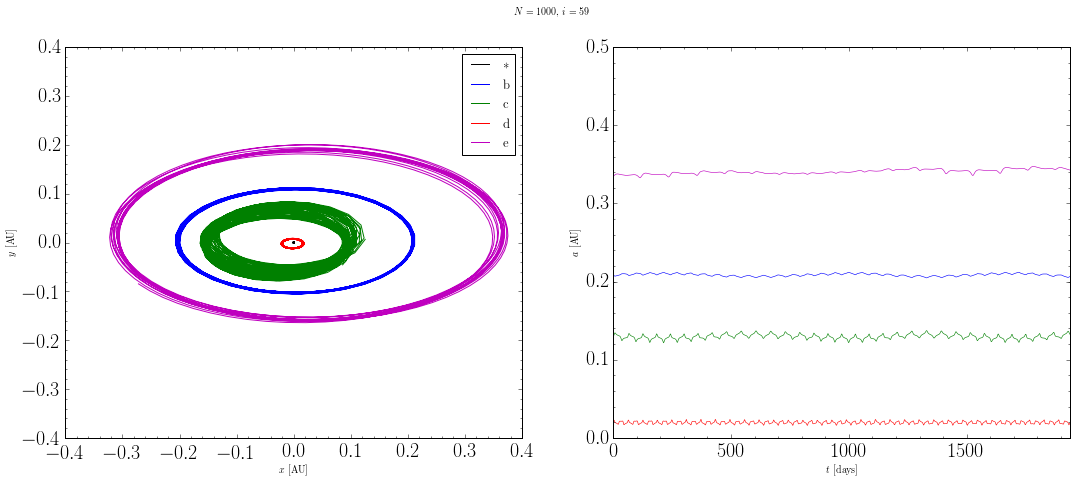

In [4]:
inc_d = 59 # True inclination
torb = P[2] # Integrate for Norb * orbital period of inner planet
Norb = 1000 # Integrate for 1000 orbits of the inner planet
Noutputs = 1000
times = np.linspace(0, Norb*torb, Noutputs)

x_sim, y_sim, vz_sim, a_sim, w_sim, e_sim = calculate_orbit(torb, inc_d, times, save=True)

plot_orbit(x_sim, y_sim, a_sim, times, save=True)

The planets look stable at $i = 59$, so we will iterate over a grid of inclinations to find the minimum inclination at which the system appears to sustain some stability. We calculate the orbital parameters for $i = [1,50]$, and plot the standard deviation as a function of $i$.

In [5]:
inc_rng = [1,50]
torb = P[2]
Norb = 1000
Noutputs = 1000
times = np.linspace(0, Norb*torb, Noutputs)
test_inc = np.arange(inc_rng[0], inc_rng[1], 1)

for inc_d in tqdm.tqdm(test_inc):
    x_sim, y_sim, vz_sim, a_sim, w_sim, e_sim = calculate_orbit(torb, inc_d, times, save=True)
    plot_orbit(x_sim, y_sim, a_sim, times, show=False);

100%|██████████| 49/49 [02:51<00:00,  3.53s/it]


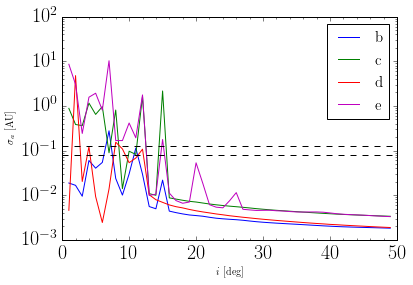

In [8]:
# ========================
# Load semi-major axis saved results
# ========================

a_std = []
for inc_d in test_inc:
    a_sim = np.load('results/N1000_i{}_a.npy'.format(inc_d))
    a_std.append(np.std(a_sim, axis=0))
a_std = np.array(a_std).T

# ========================
# Plot standard deviation of semi-major axis vs inclination
# ========================

for k in range(1,N+1):
    plt.plot(test_inc, a_std[k], color=colors[k], label='{}'.format(names[k]))
plt.axhline(min(np.diff(np.sort(a))), color='k', linestyle='--')
plt.axhline(max(np.diff(np.sort(a))), color='k', linestyle='--')
plt.ylabel(r'$\sigma_{a}$ [AU]')
plt.xlabel(r'$i$ [deg]')
# plt.ylim(0,.5)
plt.yscale('log')
plt.legend(loc='upper right', fontsize=15)
plt.minorticks_on()
plt.savefig('plots/std_a.png')
plt.show()

The black dotted lines indicate the maximum and minimum planet separations. As long as the standard deviation does not traverse this region of the plot, we have found a stability region. We find that the smallest inclination at which the orbits appear to stabilize for some period of time is approximately $i = 12$. Thus, for 1000 orbits of the inner planet, we identify $i = 12$ as the inclination that will give us the upper limit on the mass. We calculate this upper limit using our mass inclination-equation.

In [9]:
m*np.sin(i)/np.sin(12*math.pi/180)

array([6.65267941e-03, 2.08795203e-03, 6.13931568e-05, 1.34480248e-04])

To find the lower limit on the mass, we trivially set $i=90$. According to \textit{Excoplanets: Detection, Formation, Properties, Habitability} by J. W. Mason (2008), the minimum mass is given by observations of edge-on orbits (Ch. 7.1.2). The inclination that corresponds to an edge-on orbit, i.e., where the planets can be observed to transit, is $i = 90$.

In [10]:
m*np.sin(i)/np.sin(90*math.pi/180)

array([1.38316982e-03, 4.34109636e-04, 1.27643550e-05, 2.79600158e-05])

In [11]:
m

array([2.17227464e-03, 6.81771202e-04, 2.00464789e-05, 4.39113348e-05])

As a sanity check, we verify that the true masses for the planets from the Exoplanet Archive fall within our mass constraints.

$$m_b = 2.17227464 \times 10^{-3}$$

$$m_\textrm{min} =  1.38316982\times10^{-3} < 2.17227464 \times 10^{-3} < m_\textrm{max} = 6.65267941\times 10^{-3}$$ 

$$m_c = 6.81771202 \times 10^{-4}$$

$$m_\textrm{min} =  4.34109636\times10^{-4} < 6.81771202 \times 10^{-4} < m_\textrm{max} = 2.08795203\times 10^{-3}$$ 

$$m_d = 2.00464789 \times 10^{-5}$$

$$m_\textrm{min} =  1.27643550\times10^{-5} < 2.00464789 \times 10^{-5} < m_\textrm{max} = 6.13931568\times 10^{-5}$$ 

$$m_e = 4.39113348 \times 10^{-5}$$

$$m_\textrm{min} =  2.79600158\times10^{-5} < 4.39113348 \times 10^{-5} < m_\textrm{max} = 2.79600158\times 10^{-5}$$ 

### Problem 3 

We want to compute the radial velocity of the star, and then fit this RV with four Keplerian orbits. Recycling our code from HW #1, we define Kepler solver functions. As usual, our function $g(E, e, M) = E - e\sin(E) - M$ will return the error on the solution to Kepler's equation, where $E$ is the eccentric anomaly, $e$ is the eccentricity, and $M$ is the mean anomaly. We will optimize over our function for g using Newton's method.In this method, we initialize the function with a starting guess for the zeroth E given by:

$$E_0 = M + 0.85 * e * \textrm{sign}(\sin(M))$$ 

where "sign" indicates a conditional function that changes the sign in front of $\sin(M)$. 

We then iterate until we converge on a value for E. We accomplish this iteration by finding

$$ \frac{dg}{dE} = 1 - e * \cos(E) $$

and define each subsequent iteration of E relative to the last using the recursive relation

$$ E_{i+1} = E_i - \frac{g(E, e, M)}{(dg/dE)} $$

As long as the last value of $E$, $E_{i+1}$, exceeds the given tolerance (func **E_sol** argument "error"), we require the function to iterate until $E_{i+1}$ falls below this tolerance.

In [24]:
def g(E, e_, M_):
    """
    Return error on solution to Kepler's equation
    """
    return E - e_*np.sin(E) - M_


def E_sol(e_, M_, error=2e-16, max_iter=1e3):
    """
    Solve for E using Newton's method
    """
    # initial guess
    E = M_ + .85*e_*np.sign(np.sin(M_))

    j = 0
    # iterate until the specified precision is reached up to limited # of iterations
    while (abs(g(E, e_, M_)).any() > error) & (j < max_iter):
        E -= g(E, e_, M_)/(1 - e_*np.cos(E))
        j += 1

    return E

We now want to write functions to calculate the model-predicted radial velocity of the star with multiple planets. to simply the problem, we start by writing a function to calculate the model-predicted radial velocity of the star with **one planet** using the parameters time $t$, RV amplitude $K$, time of periastron in days $t_p$, eccentricity $e$, pericenter angle in radians $\tilde{\omega}$, and the velocity of center of mass $\gamma$. We calculate the mean anomaly from period, time, and time of periastron using the usual relation

$$M = \frac{2\pi}{P(t-t_p)} $$

We must also solve for the true anomaly $f$ using the relation

$$f = 2\arctan\left[\left(\frac{1+e}{1-e}\right)^{1/2}\tan\left(\frac{E}{2}\right)\right] $$

Finally, we find the radial velocity $v_z$ by taking

$$v_z = K\cos(f)\cos(\tilde{\omega}) - K\sin(f)\sin(\tilde{\omega}) + \gamma + Ke\cos(\tilde{\omega}) $$

as given by our radial velocity lecture materials.

In [25]:
def rv(t, K_, P_, tp_, e_, pomega_, gamma_):
    """
    Radial velocity model of the star with one planet

    K 		: rv amplitude (km/s)
    P 		: period (days)
    tp 		: time of periastron (days)
    e 		: eccentricity
    pomega 	: pericenter angle (rad)
    gamma 	: velocity of center of mass
    """

    Marr = 2*math.pi/P_ * (t - tp_)
    E = E_sol(e_, Marr)

    f = 2*np.arctan(((1+e_)/(1-e_))**.5 * np.tan(E/2))

    vz_ = K_*np.cos(f)*np.cos(pomega_) - K_*np.sin(f)*np.sin(pomega_) + gamma_ + K_*e_*np.cos(pomega_)

    return vz_

We now need to expand our one-planet stellar RV equation for a multi-planet system. We calculate the stellar RV due to each planet in the system, storing the individual RVs in an array "planet_rvs". We then sum these radial velocities to find the total radial velocity of the star due to the combined effect of the planets, "star_rv".

In [26]:
def rv_system(times, K_, P_, tp_, e_, pomega_, gamma_):
    """
    Radial velocity model of the star with multiple planets
    """
    
    planet_rvs = []
    for k in range(len(K_)):
        vz_planet = rv(times, K_[k], P_[k], tp_[k], e_[k], pomega_[k], gamma_[k])
        planet_rvs.append(vz_planet)
        
    planet_rvs = np.array(planet_rvs)
    star_rv = np.sum(planet_rvs, axis=0)

    return star_rv, planet_rvs

To fit the data, we will calculate the $\chi^2$ value using the usual relation

$$\chi^2 = \frac{(\textrm{model} - \textrm{data})^2}{\textrm{error}^2} $$

We will then use the Nelder-Mead optimization to fit the data.

In [27]:
def plot_model(times, y_data, y_err, y_model, **kwargs):
    
    chi2 = np.sum((y_model - y_data)**2/y_err**2)

    plt.figure(figsize=[16,8])
    plt.plot(times, y_data, color='k', label='Simulation')
    plt.plot(times, y_model, color='r', label='Keplerian Model')
    plt.plot(times, y_data - y_model, color='g', alpha=.3, label='Residual')
    plt.xlim(0, max(times))
    plt.legend(loc='upper right', fontsize=15)
    plt.title(r'$\chi^2=%s$'%(round(chi2)))
    plt.ylabel(r'RV [m s$^{-1}$]')
    plt.xlabel('time [days]')
    plt.minorticks_on()
    plt.tight_layout()
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()

Since this is simulated data, we do not have stellar RV errors. Thus, we set all stellar RV errors to 1.

In [28]:
inc_d = 59
torb = P[3]
Norb = 10
Noutputs = 1000
times = np.linspace(0, Norb*torb, Noutputs)

x_sim, y_sim, vz_sim, a_sim, w_sim, e_sim = calculate_orbit(torb, inc_d, times, save=False)
star_rv_sim = (vz_sim.T[0] * u.AU/u.day).to(u.m/u.s).value
star_rv_err = np.ones(len(star_rv_sim))

Before we can use the optimization function to perform our fit, we will want to first determine a reasonable initial guess for the parameters. We will initialize $K$ and $e$ using the literature values. We will initialize $\tilde{\omega}$ and $\gamma$ at 0 since the vertical offset of the model appears to be 0. Finally, we use by-eye estimates to guess that the horizontal offsets of the model give $t_p = [-5, 18, 0, 0]$ for each of the 4 planets.

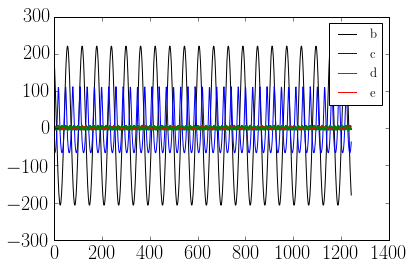

In [31]:
K_init = K
e_init = e
pomega_init = np.zeros(N)
gamma_init  = np.zeros(N)
tp_init = np.array([-5,18,0,0])

star_rv_model, planet_rvs = rv_system(times, K_init, P, tp_init, e_init, pomega_init, gamma_init)

# =====================
# Plot each planet rv
# =====================

for k in range(N):
    plt.plot(times, planet_rvs[k], color=colors[k], label='{}'.format(names[k+1]))
plt.legend(loc='upper right', fontsize=13);

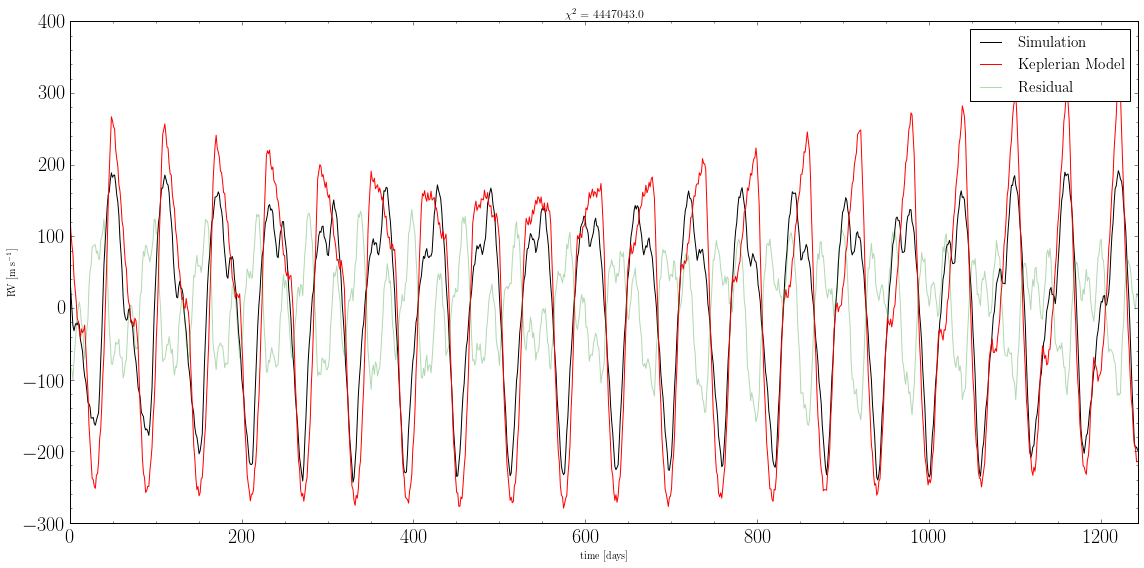

In [30]:
plot_model(times, star_rv_sim, star_rv_err, star_rv_model, save='plots/initial_fit.png')

Our plot shows that our initial guesses are reasonable, but there is certainly room for improvement in the fit. Thus, we will use the Nelder-Mead method to optimize the fit. We will assume a Gaussian likelihood function and a uniform prior for all model parameters. We then plot our fit again with the new optimized parameters.

In [32]:
def log_likelihood(theta, data, P):
    """
    Assume Gaussian likelihood function
    """
    K, tp, e, pomega, gamma = np.split(theta, 5)
    times, rv, rv_err = data
    
    rv_model = rv_system(times, K, P, tp, e, pomega, gamma)[0]
    
    return -0.5 * np.sum((rv - rv_model)**2/rv_err**2)


def log_prior(theta):
    """
    Assume uniform prior for all model parameters 
    """
    K, tp, e, pomega, gamma = np.split(theta, 5)
    
#     print(np.all(K < bounds[0][1]), np.all(K > bounds[0][0]), \
#           np.all(tp < bounds[1][1]), np.all(tp > bounds[1][0]), \
#           np.all(e < bounds[2][1]), np.all(e > bounds[2][0]), \
#           np.all(pomega < bounds[3][1]), np.all(pomega > bounds[3][0]), \
#           np.all(gamma < bounds[4][1]), np.all(gamma > bounds[4][0]))

    if np.all(K < bounds[0][1]) & np.all(K > bounds[0][0]) \
        & np.all(tp < bounds[1][1]) & np.all(tp > bounds[1][0]) \
        & np.all(e < bounds[2][1]) & np.all(e > bounds[2][0]) \
        & np.all(pomega < bounds[3][1]) & np.all(pomega > bounds[3][0]) \
        & np.all(gamma < bounds[4][1]) & np.all(gamma > bounds[4][0]):
        return 0.0
    
    return -np.inf


def log_probability(theta, data, P):
    """
    Mulitply prior and likelihood
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta, data, P)

In [33]:
nlp = lambda *args: -log_probability(*args)

initial = np.array([K_init, tp_init, e_init, pomega_init, gamma_init]).flatten()
bounds  = [(0,250), (-100,100), (0,1), (0,2*math.pi), (-50,50)]
data    = [times, star_rv_sim, star_rv_err]

soln = minimize(nlp, initial, method='nelder-mead', args=(data, P))

In [34]:
print('initial:', initial)
print('final:', soln.x)
print('success:', soln.success)

('initial:', array([ 2.1386e+02,  8.8720e+01,  6.6000e+00,  3.4200e+00, -5.0000e+00,
        1.8000e+01,  0.0000e+00,  0.0000e+00,  3.2400e-02,  2.5591e-01,
        2.0700e-01,  5.5000e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]))
('final:', array([ 1.57355464e+02,  4.31988427e+01,  7.56839463e+00,  2.03550614e+00,
       -6.61619844e+00,  1.84406967e+01,  3.72054341e-03, -2.20086940e-03,
        4.83071313e-06,  4.98127575e-05,  1.35198610e-01,  9.90512390e-02,
        2.39668047e-04,  8.88457663e-10,  1.84924356e-03,  1.49350162e-03,
        3.06785577e-03,  1.93967939e-03, -1.62602975e-03,  4.93250596e-03]))
('success:', False)


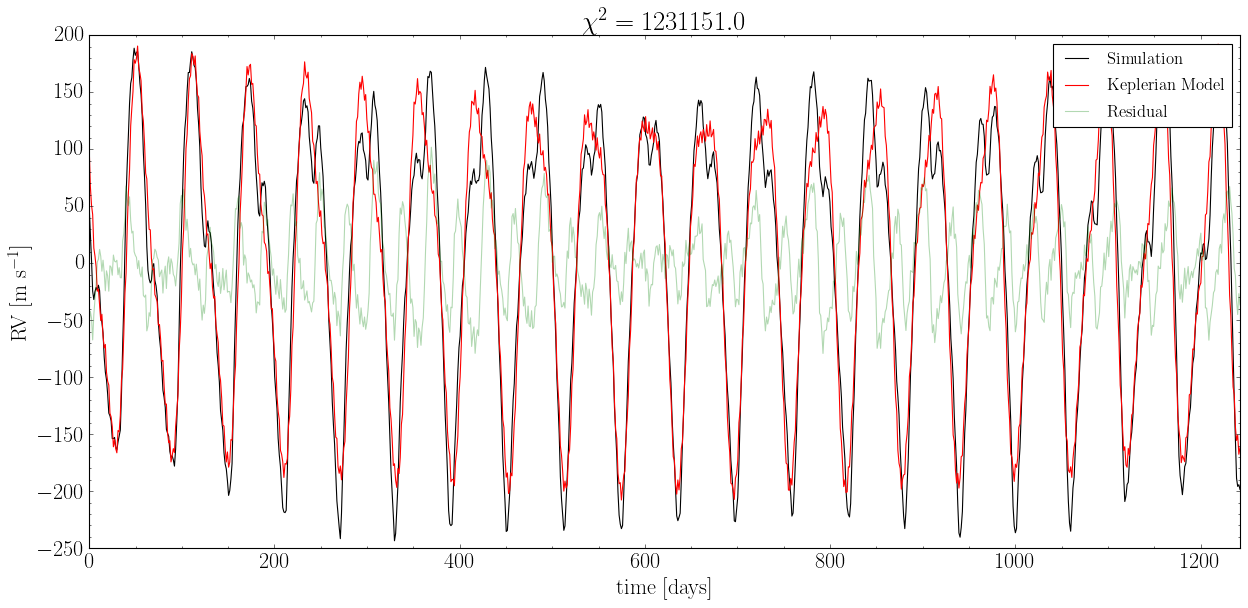

In [304]:
K_sol, tp_sol, e_sol, pomega_sol, gamma_sol = np.split(soln.x, 5)
star_rv_model, planet_rvs = rv_system(times, K_sol, P, tp_sol, e_sol, pomega_sol, gamma_sol)

plot_model(times, star_rv_sim, star_rv_err, star_rv_model, save='plots/final_fit.png')

Our new fit looks much better than the initial fit. Though the $\chi^2$ is still somewhat large, we can see that the model somewhat fits the data. We do not anticipate a perfect fit, since we know that this multi-planet system is highly perturbed due to the mutual interactions between the planetary orbits. Thus, we do not expect that a Keplerian order should perfectly describe the system.

We now display the initial and optimized parameters in a table.

In [291]:
for k in range(N):
    display(pd.DataFrame(data={'K_%s'%(names[k+1]):[K_init[k], K_sol[k]], 'tp_%s'%(names[k+1]):[tp_init[k], tp_sol[k]], \
                              'e_%s'%(names[k+1]):[e_init[k], e_sol[k]], 'pomega_%s'%(names[k+1]):[pomega_init[k], pomega_sol[k]], \
                              'gamma_%s'%(names[k+1]):[gamma_init[k], gamma_sol[k]]}, index=['initial', 'final']))

,K_b,tp_b,e_b,pomega_b,gamma_b
initial,213.860000,-5.000000,0.032400,0.00000,0.000000
final,157.355464,-6.616198,0.000005,0.00024,0.003068


,K_c,tp_c,e_c,pomega_c,gamma_c
initial,88.720000,18.000000,0.25591,0.000000e+00,0.00000
final,43.198843,18.440697,0.00005,8.884577e-10,0.00194


,K_d,tp_d,e_d,pomega_d,gamma_d
initial,6.600000,0.000000,0.207000,0.000000,0.000000
final,7.568395,0.003721,0.135199,0.001849,-0.001626


,K_e,tp_e,e_e,pomega_e,gamma_e
initial,3.420000,0.000000,0.055000,0.000000,0.000000
final,2.035506,-0.002201,0.099051,0.001494,0.004933


Our worst guesses appear to be the RV amplitudes due to planets b and c. Looking back at our initial plot tracing the planets' orbits, this makes sense. Planet b and c appear to transit closer to each other than any of the other planets. This suggests that their radial velocities should differ the most from Keplerian prediction due to the fact that they highly perturb each other as they pass closely. 

For a fit with 1000 dof, we would expect a $\chi^2 \sim 1000$. However, our fit produced $\chi^2 \sim 1\times 10^6$, further proof that the Keplerian orbits do not perfectly describe the dynamical intricacies of the system.

### Problem 4

We now want to make a plot of the TTVs of GJ 876 c over 4 years. We will assume the orbits are edge-on with $i=90$, so that planet c would be seen to transit.

/Users/samanthagilbert/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


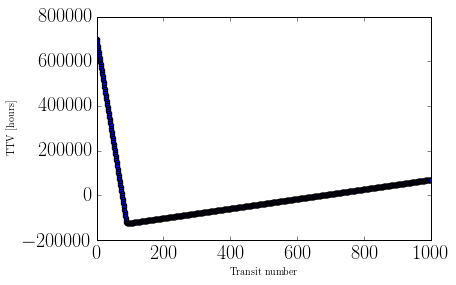

In [55]:
# Stellar parameters
mstar = .32 

# Planet parameters [b, c, d, e]
P = np.array([61.1166, 30.0881, 1.937780, 124.26])
a = np.array([0.208317, 0.129590, 0.02080665, 0.3343])
e = np.array([0.0324, 0.25591, 0.207, 0.055])
mass = np.array([2.2756, 0.7142, 0.021, 0.046]) * const.M_jup.value / const.M_sun.value
w = np.array([234, 48.76, 50.3, 239]) * math.pi/180
Mea = np.array([355, 294.59, 325.7, 335]) * math.pi/180
K = np.array([213.86, 88.72, 6.60, 3.42])

sim = rebound.Simulation()

sim.add(m=mstar)
sim.add(m=inclination_mass(inc, mass[1]), e=e[1], a=a[1], omega=w[1]) # add planet c using parameters we set before
sim.move_to_com()


N = 1000  # Integrate over 4 transits for planet b
inc = inc_d * math.pi/180
transittimes = np.zeros(N)
p = sim.particles
i = 90 # assume edge-on orbit
while i<N:
    y_old = p[1].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[1].y-p[0].y)<0. and p[1].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[1].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit
        
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes)[0]

ax = plt.subplot(111)
ax.set_xlim([0,N])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")
plt.scatter(range(N), (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi));